<h1><center>Введение в sklearn. Общий интерфейс моделей.</center></h1>


In [1]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
%config InlineBackend.figure_format = 'retina'

Рассмотрим, каким образом тренируется большинство контролируемых моделей, формат данных, простые метрики

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

Большинство моделей контролируемого обучения занимаются предсказаниями вида $y = \hat{f}(\vec{x})$. Поскольку тренировка и предсказания обычно производятся со множеством экземпляров (примеров) данных $\vec{x}$, то типичный интерфейс в sklearn для тренировки, предсказаний, метрик и трансформаций, принимает экземпляры в виде матрицы $X$ (по строке на экземпляр) и вектора $\vec{y}$ (если нужно):
\begin{equation*}
X = \begin{bmatrix}
     x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_M \\
     ... \\
     x^{(N)}_1 & x^{(N)}_2 & ... & x^{(N)}_M \\
    \end{bmatrix}, 
    \vec{y} =  \begin{bmatrix} y_1 \\ ... \\ y_N \end{bmatrix}
\end{equation*}
, где $M$ - количество признаков (атрибутов), используемых моделью, а $N$ - количество экземпляров данных.

### Iris Dataset

В качестве простейшего набора данных можно воспользоваться набор Ирисы Фишера. 
В нем по четырём признакам (длина/ширина лепестка/чашелистика) нужно определить, к какому из трех подвидов ириса относится растение. 
Набор данных встроен в sklearn, как демо, поэтому нам не нужно вручную преобразовывать данные в формат $X$, $\vec{y}$.

In [3]:
from sklearn.datasets import load_iris

In [4]:
iris = load_iris()

Выделим отсюда атрибуты экземпляров (матрицу $X$) и их классы ($\vec{y}$)

In [5]:
X = iris.data
print(iris.feature_names) # Имена атрибутов (столбцов)
print(X[::15]) # выведем каждую 15й пример

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [5.7 4.4 1.5 0.4]
 [4.8 3.1 1.6 0.2]
 [4.8 3.  1.4 0.3]
 [5.  2.  3.5 1. ]
 [6.6 3.  4.4 1.4]
 [5.5 2.6 4.4 1.2]
 [7.6 3.  6.6 2.1]
 [6.9 3.2 5.7 2.3]
 [7.7 3.  6.1 2.3]]


In [6]:
y = iris.target
print(iris.target_names) # Имена классов (первому имени соотв. метка 0, второму 1, ...)
print(y[::15])

['setosa' 'versicolor' 'virginica']
[0 0 0 0 1 1 1 2 2 2]


Можно заметить, что набор данных отсортирован по классу

Данные 4х-мерные, поэтому мы можем визуализировать только часть измерений.
Раскрасим точки в зависимости от класса в красный, зеленый и синий. 
Отобразим все уникальные комбинации из двух атрибутов. Всего их $\frac{M(M-1)}{2} = 6$

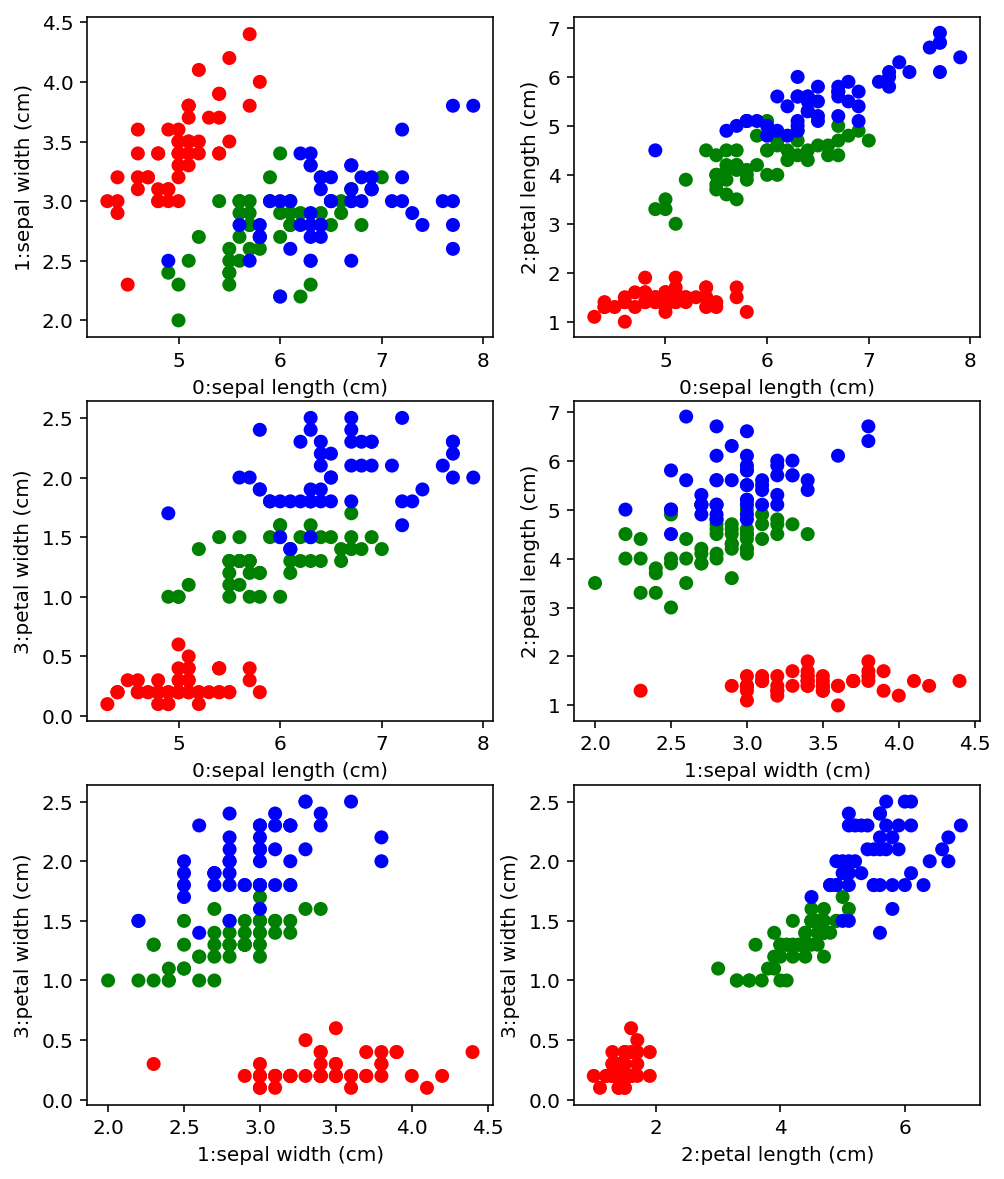

In [7]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green', 'blue'])

fig = plt.figure(figsize=(8, 10))
k = 1
for i in range(4):
    for j in range(i+1,4):
        attr1_name = str(i) + ':' + iris.feature_names[i]
        attr2_name = str(j) + ':' + iris.feature_names[j]
        ax = fig.add_subplot(3,2,k)
        ax.scatter(X[:,i],X[:,j], cmap=cmap, c=y)
        ax.set_xlabel(attr1_name)
        ax.set_ylabel(attr2_name)
        k += 1

plt.show()

Как можно заметить, даже по двум признакам эти данные близки к линейно разделяемым

В общем случае, тренировка и предсказания делаются по всем атрибутам (или по отобранным специфическим образом, например по метрикам оценки зависимости между атрибутом и выходной переменной), но в целях визуализации, для начала поработаем только с двумя атрибутами. 

### Работа  с двумя классами

Для начала, рассмотрим логистическую регрессию на <b>двух</b> классах. Исключим класс 0 (setosa, красный на графике) и возьмем признаки 1 (sepal width) и 2 (petal length).

In [8]:
exclude_class = (y != 0)
Xb = X[exclude_class]
Xb = Xb[:,[1,2]]
yb = y[exclude_class]
yb -= 1 # Превращаем единицы в нули, а двойки в единицы
class_names = iris.target_names[1:]
feature_names = [iris.feature_names[i] for i in [1,2]]

Отобразим оставшиеся данные

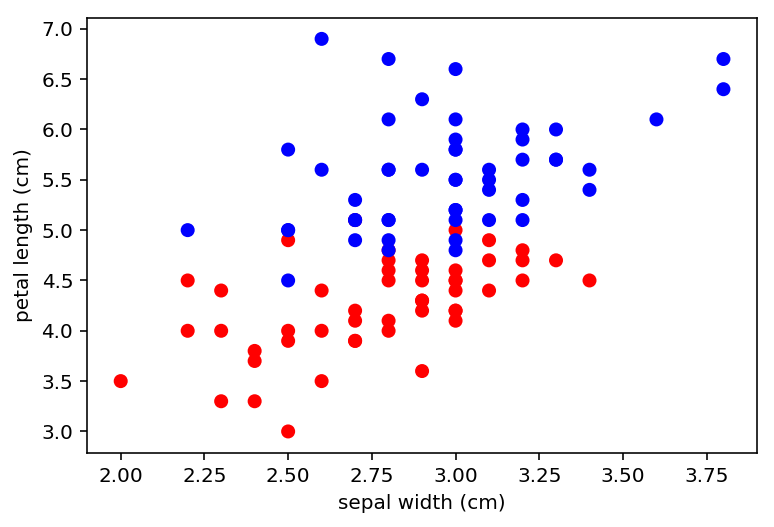

In [9]:
fig = plt.figure()
ax = fig.add_subplot('111')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.scatter(Xb[:,0],Xb[:,1],cmap=cmap, c=yb)

### Разбиение данных на обучающие и тестовые

Основная цель машинного обучения - получение моделей способных работать с реальными (общими) данными. Производительность на данных, использованных для обучения, сама по себе имеет куда меньший смысл. Поэтому необходимо разделить данные на обучающие и используемые для проверки.

С одной стороны, это можно сделать руками.

In [10]:
indices = np.random.permutation(np.arange(len(yb))) # Данные отсортированы, поэтому их необходимо перемешать
# получаем перемешанные индексы.
Xb_shuffled, yb_shuffled = Xb[indices], yb[indices]
# Берем часть данных в обучающую, часть в тестовую выборку
Xb_train, Xb_test = Xb_shuffled[:80], Xb_shuffled[80:] #всего 100 точек, 80 в обучающую, 20 в тестовую
yb_train, yb_test = yb_shuffled[:80], yb_shuffled[80:]

print(yb_test)

[0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0]


В итоге, в тестовую выборку экземпляров классов 1 и 2 попало примерно поровну. <br>
Однако, эта операция достаточно рутинна, и чтобы не мучиться, можно использовать средства sklearn.

In [11]:
from sklearn.model_selection import train_test_split

train_test_split выполняет разбиение с различными опциями, такими как:<br>
    &nbsp; Пропорция тестовых экземпляров (test_size) <br>
    &nbsp; Нужно ли перемешать данные (shuffle) <br>
    &nbsp; Сохранить ли пропорцию классов в выборках (stratify) (актуально для несбалансированных наборов данных, где случайно можно потерять из выборки все экземпляры одного класса).

In [12]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, shuffle=True, stratify=yb)

Теперь пропорция классов в выборках одинаковая и составляет 50% на 50%

In [13]:
print(yb_test, yb_test[yb_test==0].size, yb_test[yb_test==1].size)

[0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1] 10 10


### Бинарная логистическая регрессия

Бинарная логистическая регрессия - это вероятностная модель, предсказывающая вероятность одного из двух классов $p(y=1 ~|~\vec{x}) = p(1~|~\vec{x})$.

Как следствие $p(0~|~\vec{x}) = 1 - p(1~|~\vec{x})$. При этом:

\begin{equation*}
p(1~|~\vec{x}) = \sigma(w_1 x_1 + ... w_m x_m + b) = \sigma(\vec{w} \cdot \vec{x} + b)
\end{equation*}

\begin{equation*}
\sigma(z) = \frac{1}{1 + e^{-z}}
\end{equation*}

Модель предсказывает класс 1, если $p(1 ~|~\vec{x}) > 0.5$, и 0 в противном случае, а $p(c~|~\vec{x})$ может использоваться как показатель уверенности предсказания. 
Отметим, что $\sigma(z)$ монотонно возрастает, и $\sigma(0) = 0.5$, т.е. гиперплоскость, заданная уравнением $\vec{w} \cdot \vec{x} + b = 0$ разделяет пространство на два региона, где точкам назначается соответствующий региону класс. Таким образом $\vec{w} \cdot \vec{x} + b = 0$ является <em>линейным разделителем</em> классов.

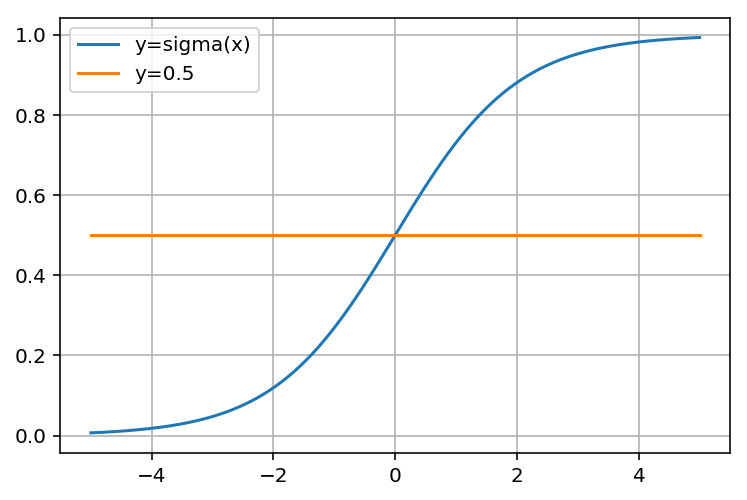

In [14]:
xx = np.linspace(-5,5,100)
ss = 1 / (1 + np.exp(-xx))
plt.plot(xx,ss, label='y=sigma(x)')
plt.plot([xx[0],xx[-1]], [0.5, 0.5], label='y=0.5')
plt.grid()
plt.legend()
plt.show()

Натренируем модель и оценим её точность (процент угаданных в тестовой выборке примеров). <br>
Тренировка моделей (любых, включая неконтролируемые и преобразования) производится с помощью метода <b>fit</b>, куда отправляются обучающие данные. Предсказания модели для набора экземпляров -- с помощью метода <b>predict</b>. <br>
Оценить точность можно с помощью функции accuracy_score (пропорция правильно назначенных классов) из модуля metrics, хотя это плохая оценка модели если классы не представлены равномерно.

In [15]:
from sklearn import linear_model, metrics

In [16]:
logr = linear_model.LogisticRegression() # у нее много параметров, но не будем ничего делать
# тренируем модель
logr.fit(Xb_train, yb_train)
# предсказываем классы на тестовых данных
yb_pred = logr.predict(Xb_test)
# Сравниваем правильные предсказания с таковыми у модели
print("Accuracy", metrics.accuracy_score(yb_test, yb_pred)) 
print(yb_test)
print(yb_pred)

Accuracy 0.95
[0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1]
[0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1]


/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Вообще говоря, эта оценка зависит от того, какие выборки использовались для тренировки и модели. Но вероятность получить идеальные предсказания для 20 тестовых экземпляров по двум признакам очень мала.

У модели есть атрибуты .coef_ и .intercept_ -- веса и смещение линейного разделителя

In [17]:
print(logr.coef_)
print(logr.intercept_)
print(feature_names)

[[-2.20753819  1.77006577]]
[-2.15265737]
['sepal width (cm)', 'petal length (cm)']


Можно отметить, что признак 1 (sepal width (cm)) негативно влияет на вероятность класса 1, а признак 2 (petal length (cm)) - позитивно.

Построим линейный разделитель на графике. $w_1 x_1 + w_2 x_2 + b = 0$, следовательно $x_2 = -\frac{w_1 x_1 + b}{w_2}$

Отобразим его вместе с точками в обучающей выборке (под которую модель оптимизирована) и точками в тестовой выборке (которые модель не видела раньше).

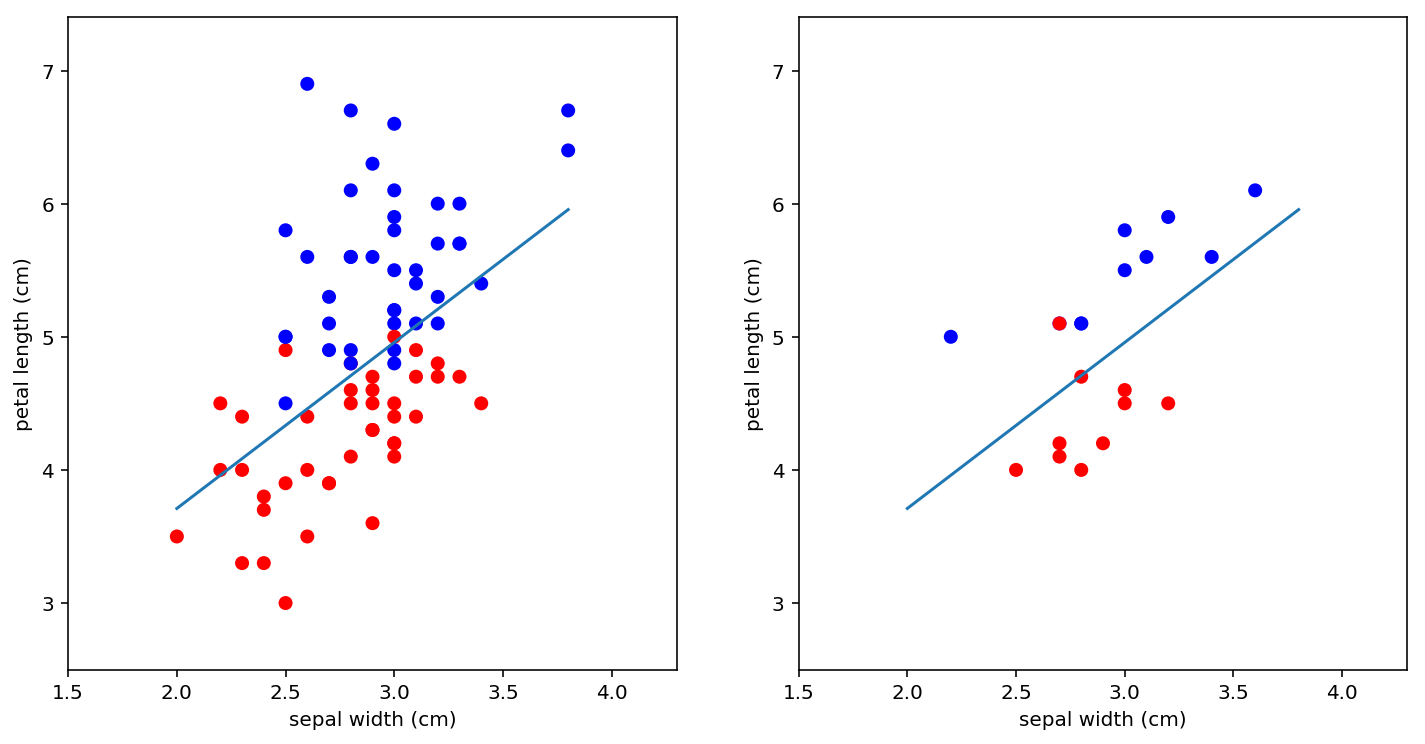

In [18]:
w1, w2 = logr.coef_[0]
b = logr.intercept_[0]
fig = plt.figure(figsize=(12,6))



x1_min, x1_max = Xb[:,0].min(), Xb[:,0].max() # проведем сепаратор между двумя точками
x2_min, x2_max = Xb[:,1].min(), Xb[:,1].max() # вычислим для одинакового масштаба

xx1 = np.array([x1_min, x1_max])
sep = -(w1 * xx1 + b) / w2

ax = fig.add_subplot('121')
ax.scatter(Xb_train[:,0], Xb_train[:,1], cmap=cmap, c=yb_train)
ax.set_xlim(x1_min - 0.5, x1_max + 0.5)
ax.set_ylim(x2_min - 0.5, x2_max + 0.5)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.plot(xx1, sep)

ax = fig.add_subplot('122')
ax.scatter(Xb_test[:,0], Xb_test[:,1], cmap=cmap, c=yb_test)
ax.set_xlim(x1_min - 0.5, x1_max + 0.5)
ax.set_ylim(x2_min - 0.5, x2_max + 0.5)
ax.plot(xx1, sep)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
plt.show()


Альтернативный способ отображения границ принятия решений (и более универсальный) - это вычисление функции на сетке значений.
Мы также можем отобразить вероятности, как уровни уверенности в предсказании (график 2 и контурный график 3)

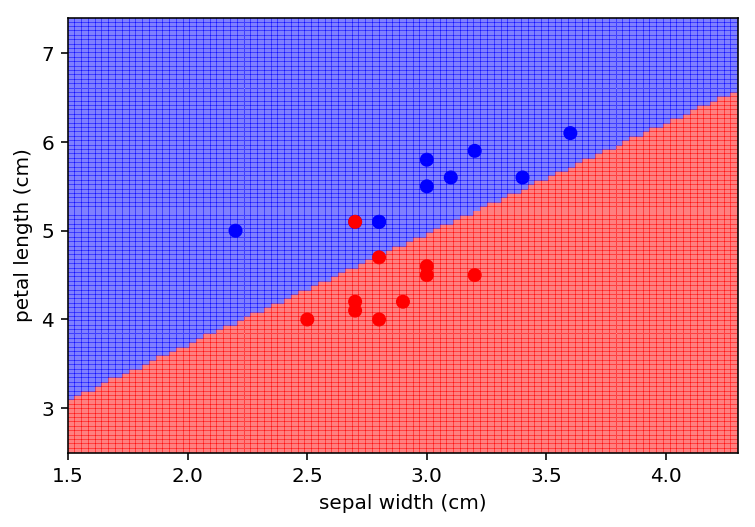

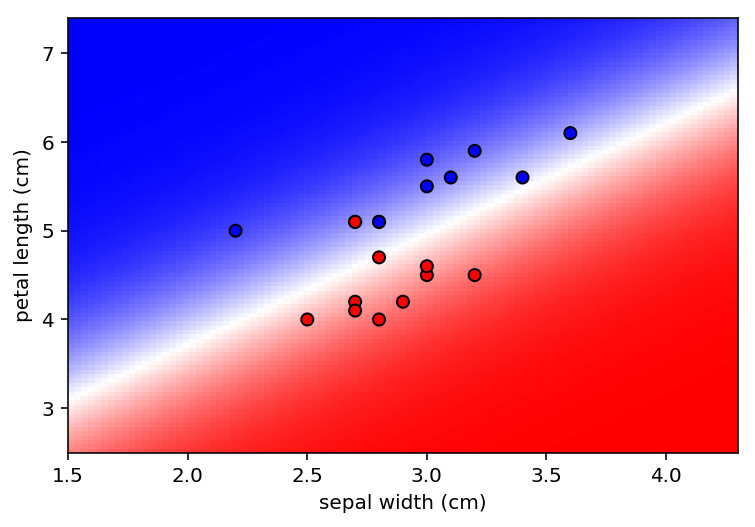

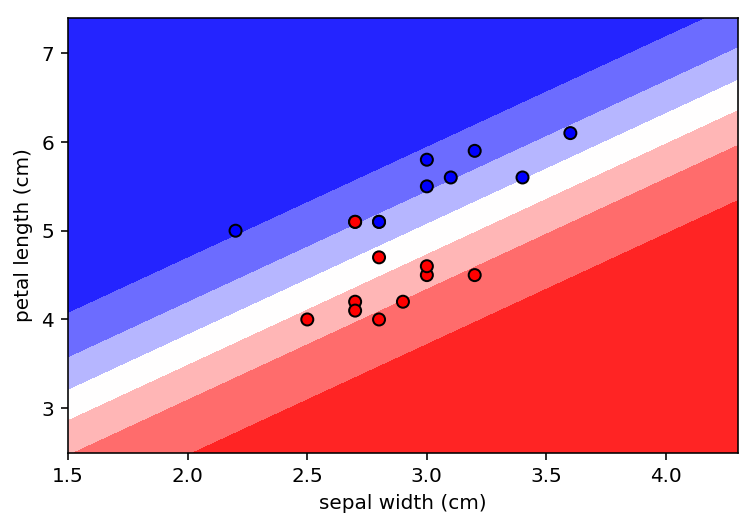

In [19]:
fig = plt.figure()
ax = fig.add_subplot('111')


xx1, xx2 = np.mgrid[x1_min - 0.5:x1_max+0.5:100j, x2_min - 0.5:x2_max+0.5:100j]
X_grid = np.column_stack((xx1.ravel(),xx2.ravel())) # теперь в X_grid 10000 пар точек (декартово произведение)
grid_pred = logr.predict(X_grid)
ax.pcolormesh(xx1, xx2, grid_pred.reshape(xx1.shape), alpha=0.5, cmap=cmap)
ax.scatter(Xb_test[:,0], Xb_test[:,1], cmap=cmap, c=yb_test)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
plt.show()

from matplotlib import cm
smooth_cmap = cm.get_cmap('bwr') #Схема синий-белый-красный, к сожалению не нашел обратной, 
 #а самому пилить влом поэтому костыль ниже
grid_prob = 1 - logr.predict_proba(X_grid)[:,1] # костыль

fig = plt.figure()
ax = fig.add_subplot('111')
ax.pcolormesh(xx1, xx2, grid_prob.reshape(xx1.shape), alpha=1, cmap=smooth_cmap)
ax.scatter(Xb_test[:,0], Xb_test[:,1], cmap=cmap, c=yb_test, edgecolors='black')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
plt.show()

fig = plt.figure()
ax = fig.add_subplot('111')
ax.contourf(xx1, xx2, grid_prob.reshape(xx1.shape), alpha=1, cmap=smooth_cmap)
ax.scatter(Xb_test[:,0], Xb_test[:,1], cmap=cmap, c=yb_test, edgecolors='black')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
plt.show()

### Классификация с более, чем 2 классами

Мультиномиальная логистическая регрессия - обобщение логистической регрессии на множество классов. В нашем случае, у нас имеется три класса.

Как правило под мультиномиальной лог. регрессией подразумевают softmax-регрессию. На каждый класс $c$ тренируется линейная модель вида:
\begin{equation*}
z^{(c)} = w_1^{(c)} x_1 + ... + w_m^{(c)} x_m + b^{(c)}
\end{equation*}
ЗЫ: $x^{(c)}$ - это не степень...

И вероятность каждого класса вычисляется следующим образом:
\begin{equation*}
P(c~|~\vec{x}) = \frac{exp(z^{(c)})}{\sum_{c'} exp(z^{(c')})}
\end{equation*}

Т.е. это нормализованная (чтобы вероятности суммировались в 1) экспонента $z^{(c)}$. Функция возвращающая вектор нормализованных экспонент называется softmax, т.к. для большинства входных векторов значительная часть вероятности переходит к максимальному элементу этого вектора:

In [20]:
values = np.array([4,3,5,6,2,1])
print("Normalized", np.round(values / values.sum(), 3))
print("Softmax-normalized", np.round(np.exp(values) / np.exp(values).sum(), 3))
hm = np.zeros(values.size)
hm[values.argmax()] = 1
print("Hardmax", hm)

Normalized [0.19  0.143 0.238 0.286 0.095 0.048]
Softmax-normalized [0.086 0.032 0.233 0.634 0.012 0.004]
Hardmax [0. 0. 0. 1. 0. 0.]


Выделим обучающую и тестовую выборку на случай трех классов и обучим softmax-регрессию:

In [21]:
Xb2 = X[:,[1,2]]
X_train, X_test, y_train, y_test = train_test_split(Xb2, y, test_size=0.2, stratify=y, shuffle=True)

In [22]:
mlogr = linear_model.LogisticRegression()

In [23]:
mlogr.fit(X_train, y_train)
m_pred = mlogr.predict(X_test)
print(y_test)
print(m_pred)
print("Accuracy", metrics.accuracy_score(y_test, m_pred))

[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 2 0 1 2 2 0 2 0 2 2 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 2 2 2]
Accuracy 0.8666666666666667


/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Построим границы принятия решений.

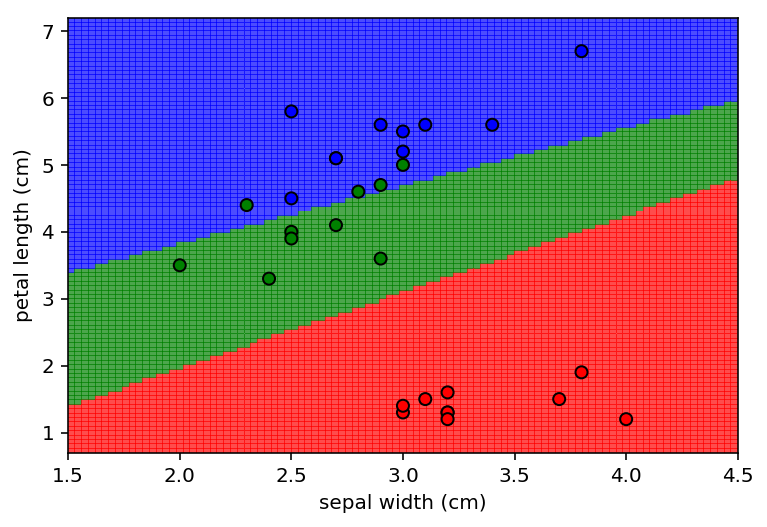

In [24]:
fig = plt.figure()
ax = fig.add_subplot('111')

x1_min, x1_max = X_test[:,0].min(), X_test[:,0].max()
x2_min, x2_max = X_test[:,1].min(), X_test[:,1].max() 
xx1, xx2 = np.mgrid[x1_min - 0.5:x1_max+0.5:100j, x2_min - 0.5:x2_max+0.5:100j]
X_grid = np.column_stack((xx1.ravel(),xx2.ravel())) 

grid_pred = mlogr.predict(X_grid)
ax.pcolormesh(xx1,xx2,grid_pred.reshape(xx1.shape), cmap=cmap, alpha=0.7)
ax.scatter(X_test[:,0], X_test[:,1], cmap=cmap, c = y_test, edgecolors='black')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
plt.show()

Аналогично, можно строить границы для других классификаторов. Рассмотрим k-ближайших соседей для разных k, и деревья решений.

In [25]:
from sklearn import neighbors, tree

K-ближайших соседей возвращает класс, принадлежащий большинству K ближайших соседей точки. Тренировки, как таковой, у него нет, он просто запоминает все точки.
Деревья решений разбивают экземпляры по значеним или интервалам атрибутов, пока в некотором интервале не окажется очевидным какой-либо класс.

knn1 :
[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 1 0 1 2 1 0 2 0 2 2 0 2 1 1 0 1 0 0 0 1 1 0 0 1 2 2 1 2 1]
Accuracy 0.8666666666666667
--------------
knn5 :
[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 1 0 1 2 1 0 2 0 2 2 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 1]
Accuracy 0.9333333333333333
--------------
knn10 :
[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 1 0 1 2 1 0 2 0 2 2 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 1]
Accuracy 0.9333333333333333
--------------
decision_tree :
[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 1 0 1 2 1 0 2 0 2 2 0 2 1 1 0 1 0 0 0 1 1 0 0 1 2 2 1 2 1]
Accuracy 0.8666666666666667
--------------


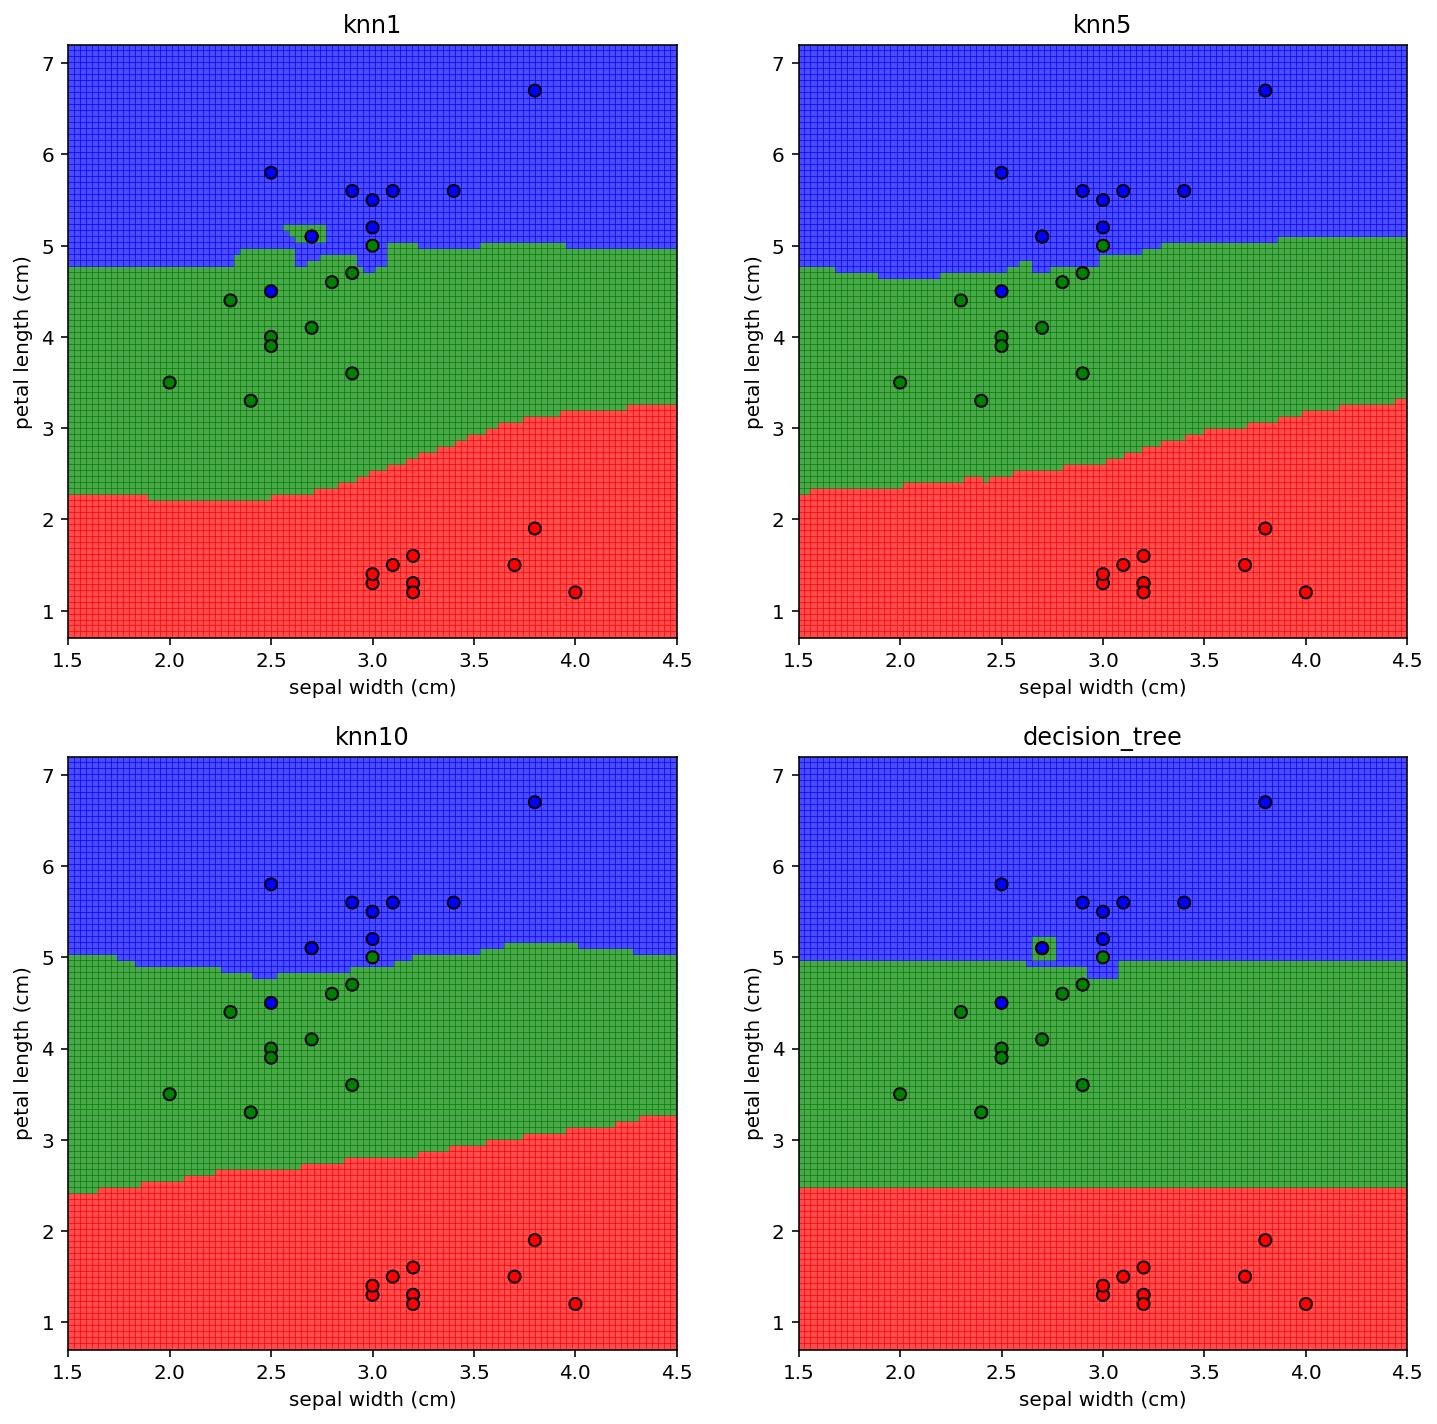

In [26]:
classifiers = [
    neighbors.KNeighborsClassifier(n_neighbors=1),
    neighbors.KNeighborsClassifier(n_neighbors=5),
    neighbors.KNeighborsClassifier(n_neighbors=10),
    tree.DecisionTreeClassifier()
]
clf_names = ['knn1', 'knn5', 'knn10', 'decision_tree']
fig = plt.figure(figsize=(12,12))
for ith, name, clf in zip(range(len(classifiers)), clf_names, classifiers):
    clf.fit(X_train, y_train)
    c_pred = clf.predict(X_test)
    
    print(name,":")
    print(y_test)
    print(c_pred)
    print('Accuracy', metrics.accuracy_score(y_test, c_pred))
    print('--------------')
    ax = fig.add_subplot(2,2,ith+1)
    
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(name)
    
    c_grid = clf.predict(X_grid)
    ax.pcolormesh(xx1, xx2, c_grid.reshape(xx1.shape), alpha=0.7, cmap=cmap)
    ax.scatter(X_test[:,0], X_test[:,1], cmap=cmap, c = y_test, edgecolors='black')

plt.show()

Отобразим дерево решений, границы которого показаны на последнем графике.

In [27]:
import graphviz # сторонняя библиотека для визуализации графов
from IPython.display import SVG, Image, HTML
dt = classifiers[3]
dot = graphviz.Source(tree.export_graphviz(dt, feature_names=feature_names, class_names=iris.target_names))
svg_bytes = dot.pipe(format='svg')
no_wrap_div = '<div style="width:70% ;height:70% ;">{}</div>'
HTML(no_wrap_div.format(svg_bytes.decode()))

Мы можем ограничить максимальную высоту дерева. С одной стороны, это понижает гибкость модели, т.е. её способность приближать сложные функции. С другой стороны, полученная модель будет обладать большей интепретируемостью, а также это снижает вероятность переобучения, т.е. запоминания моделью "закономерностей", которые свойственны только обучающей выборке и не соблюдаются в целом. Поэтому улучшение результатов на тестовом наборе вполне возможно. Поскольку разбиение по атрибутам происходит в жадном порядке (по максимальной информативности) урезание дерева снизу отсекает разбиения, которые меньше влияют на результат.

In [28]:
dt_pruned = tree.DecisionTreeClassifier(max_depth=4)
dt_pruned.fit(X_train, y_train)
dt_pred = dt_pruned.predict(X_test)
print(y_test)
print(dt_pred)
print('Accuracy', metrics.accuracy_score(y_test, dt_pred))

[1 1 0 1 2 1 0 2 0 2 1 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 2]
[1 1 0 1 2 1 0 2 0 2 2 0 2 2 1 0 1 0 0 0 2 1 0 0 1 2 2 1 2 1]
Accuracy 0.9333333333333333


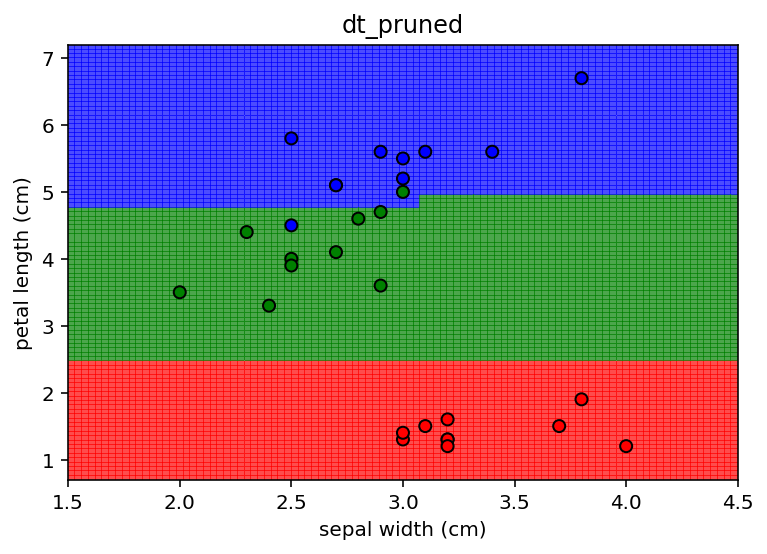

In [29]:
fig, ax = plt.subplots()
ax.pcolormesh(xx1, xx2, dt_pruned.predict(X_grid).reshape(xx1.shape), cmap=cmap, alpha=0.7)
ax.scatter(X_test[:,0], X_test[:,1], edgecolors='black', cmap=cmap, c=y_test)
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_title('dt_pruned')
plt.show()

In [30]:
dot = graphviz.Source(tree.export_graphviz(dt_pruned, feature_names=feature_names, class_names=iris.target_names))
svg_bytes = dot.pipe(format='svg')
no_wrap_div = '<div style="width:80% ;height:80% ;">{}</div>'
HTML(no_wrap_div.format(svg_bytes.decode()))

### Тренировка полной модели (все атрибуты и классы)
Теперь попробуем использовать все четыре атрибута для тренировки модели и новых предсказаний.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, stratify=y, test_size=0.2)

In [32]:
log_full = linear_model.LogisticRegression()
log_full.fit(X_train, y_train)

/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ivan/.pyenv/versions/3.6.4/envs/general36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
full_predict = log_full.predict(X_test)
print(y_test)
print(full_predict)
print("Accuracy", metrics.accuracy_score(y_test, full_predict))

[1 0 0 2 0 0 2 0 2 1 1 1 0 2 1 1 2 0 2 2 2 1 2 0 0 0 1 1 2 1]
[1 0 0 2 0 0 2 0 2 1 1 1 0 2 1 1 1 0 2 2 2 1 2 0 0 0 2 1 2 1]
Accuracy 0.9333333333333333
